# Imports and Defaults

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import pandas as pd

from src.utils.models import BayesKitModel
from src.samplers.drghmc import DrGhmcDiag

In [3]:
sns.set_theme(style="whitegrid", font_scale=1.5)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "figure.dpi": 300,
})

# Compute Log Density, Gradient, Condition Number, and Stepsize

In [4]:
model_path = "posteriors/funnel10/funnel10.stan"
data_path = None
model = BayesKitModel(model_path, data_path)

In [5]:
def get_step(x, model):
    step_sizes = [2.0, 0.5, 0.125, 0.03125, 0.0078125, 0.001953125, 0.00048828125, 0.0001220703125, 3.0517578125e-05, 7.62939453125e-06]
    
    
    sampler = DrGhmcDiag(
        model=model,
        max_proposals=len(step_sizes),
        leapfrog_step_sizes=step_sizes,
        leapfrog_step_counts=[1] * len(step_sizes),
        damping=0.08,
        init=x,
        prob_retry=False
    )
    
    _, _ = sampler.sample()
    attempt = sampler.diagnostics["acceptance"] - 1
    return step_sizes[attempt]

In [6]:
x_values, y_values = np.linspace(-9, 9, 121), np.linspace(-9, 9, 121)
grad_values = np.zeros((len(x_values), len(y_values)))
density_values = np.zeros_like(grad_values)
condition_values = np.zeros_like(grad_values)
stepsize_values = np.zeros_like(grad_values)

for i, y_val in enumerate(y_values):
    for j, x_val in enumerate(x_values):
        arr = np.array([x_val] +  [y_val] * 9)
        log_density, gradient, hessian = model.bsmodel.log_density_hessian(arr)
        
        density_values[i, j] = log_density
        grad_values[i, j] = np.linalg.norm(gradient)
        condition_values[i, j] = np.linalg.cond(hessian)
        stepsize_values[i, j] = np.mean([get_step(arr, model) for _ in range(100)])

/mnt/home/gturok/drghmc/src/samplers/drghmc.py:344: RuntimeWarning: invalid value encountered in add
  rho_mid = rho + 0.5 * step_size * grad
/mnt/home/gturok/drghmc/src/samplers/drghmc.py:345: RuntimeWarning: overflow encountered in multiply
  theta += step_size * (1 / self._metric) * rho_mid


In [54]:
data = pd.DataFrame({
    "x": np.tile(x_values, len(y_values)),
    "y": np.repeat(y_values, len(x_values)),
    "negative log density": - density_values.flatten(),
    # "gradient norm": grad_values.flatten(),
    "Hessian condition number": condition_values.flatten(),
    "DR-G-HMC stepsize": stepsize_values.flatten(),
})

# DR-GHMC Stepsize

In [50]:
data = data.melt(
    id_vars=["x", "y"],
    value_vars=["DR-G-HMC stepsize"],
    var_name="metric",
    value_name="value",
)

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


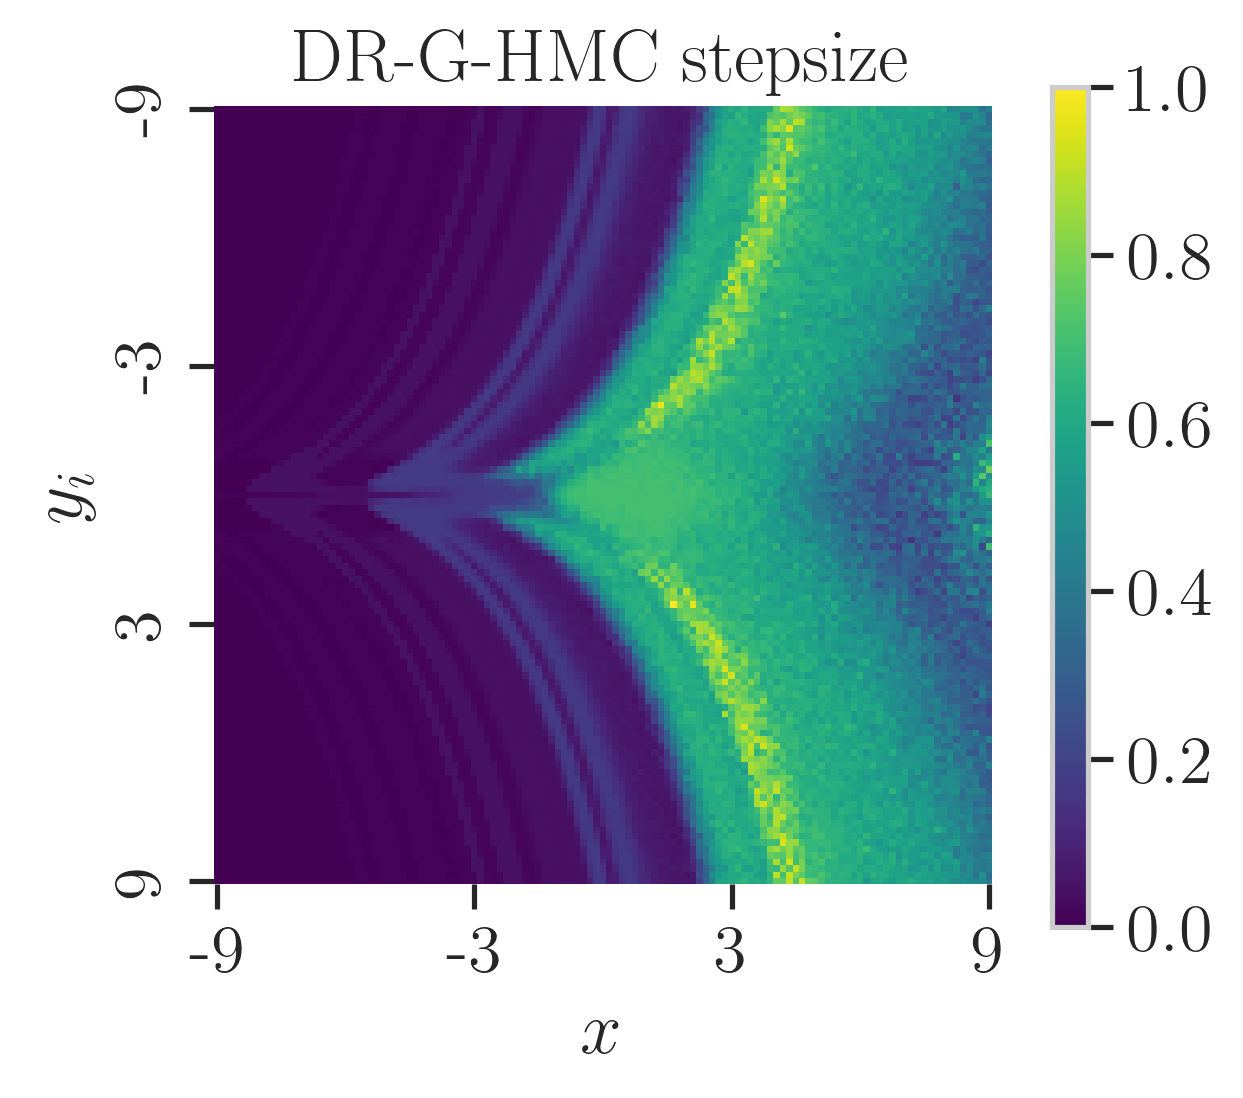

In [52]:
g = sns.FacetGrid(
    data=data,
    col_wrap=1,
    height=4,
    col="metric",
    col_order=["DR-G-HMC stepsize"],
)

def plot_heatmap(data, color, **kwargs):
    cur_data = data["value"].values.reshape(len(y_values), len(x_values))
    cur_data = pd.DataFrame(cur_data, index=y_values, columns=x_values)
    metric = data["metric"].values[0]
    # norm=SymLogNorm(linthresh=100, vmax=1e5)
    
    sns.heatmap(
        data = cur_data,
        cmap="viridis",
        cbar=False,
        # norm=norm,
        xticklabels=40,
        yticklabels=40,
        square=True,
        ax=plt.gca(),
    )
    
g.map_dataframe(plot_heatmap)

# iterate over axis and add x and y ticks
for i, ax in enumerate(g.axes.flat):
    ax.xaxis.tick_bottom()
    if i == 0:
        ax.yaxis.tick_left()
    # cbar = ax.collections[0].colorbar
    # cbar.ax.tick_params(size=0)    

plt.subplots_adjust(right=0.8)
plt.colorbar(label="", mappable=plt.cm.ScalarMappable(cmap="viridis"), cax=g.fig.add_axes([0.85, 0.15, 0.03, 0.7]))
g.set_xlabels(r"$x$")
g.set_ylabels(r"$y_i$")
# set the ticks and tick labels
g.set_xticklabels(labels=[f"{x:.0f}" for x in x_values[::40]])
g.set_yticklabels(labels=[f"{y:.0f}" for y in y_values[::40]])
g.set_titles(col_template="{col_name}")

# Figure

In [55]:
data = data.melt(
    id_vars=["x", "y"],
    # value_vars=["log density", "Hessian condition number", "DR-GHMC stepsize"],
    value_vars=["negative log density", "Hessian condition number"],
    var_name="metric",
    value_name="value",
)

In [56]:
def get_norm(metric):
    if metric == "negative log density":
        norm = SymLogNorm(linthresh=1e1)
        norm = SymLogNorm(linthresh=25, vmin=-1e0, vmax=1e5)
    elif metric == "Hessian condition number":
        norm = LogNorm(vmin=1e0, vmax=1e5)
    elif metric == "DR-GHMC stepsize":
        norm = None
    else:
        raise ValueError(f"Unknown metric {metric}")
    return norm

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


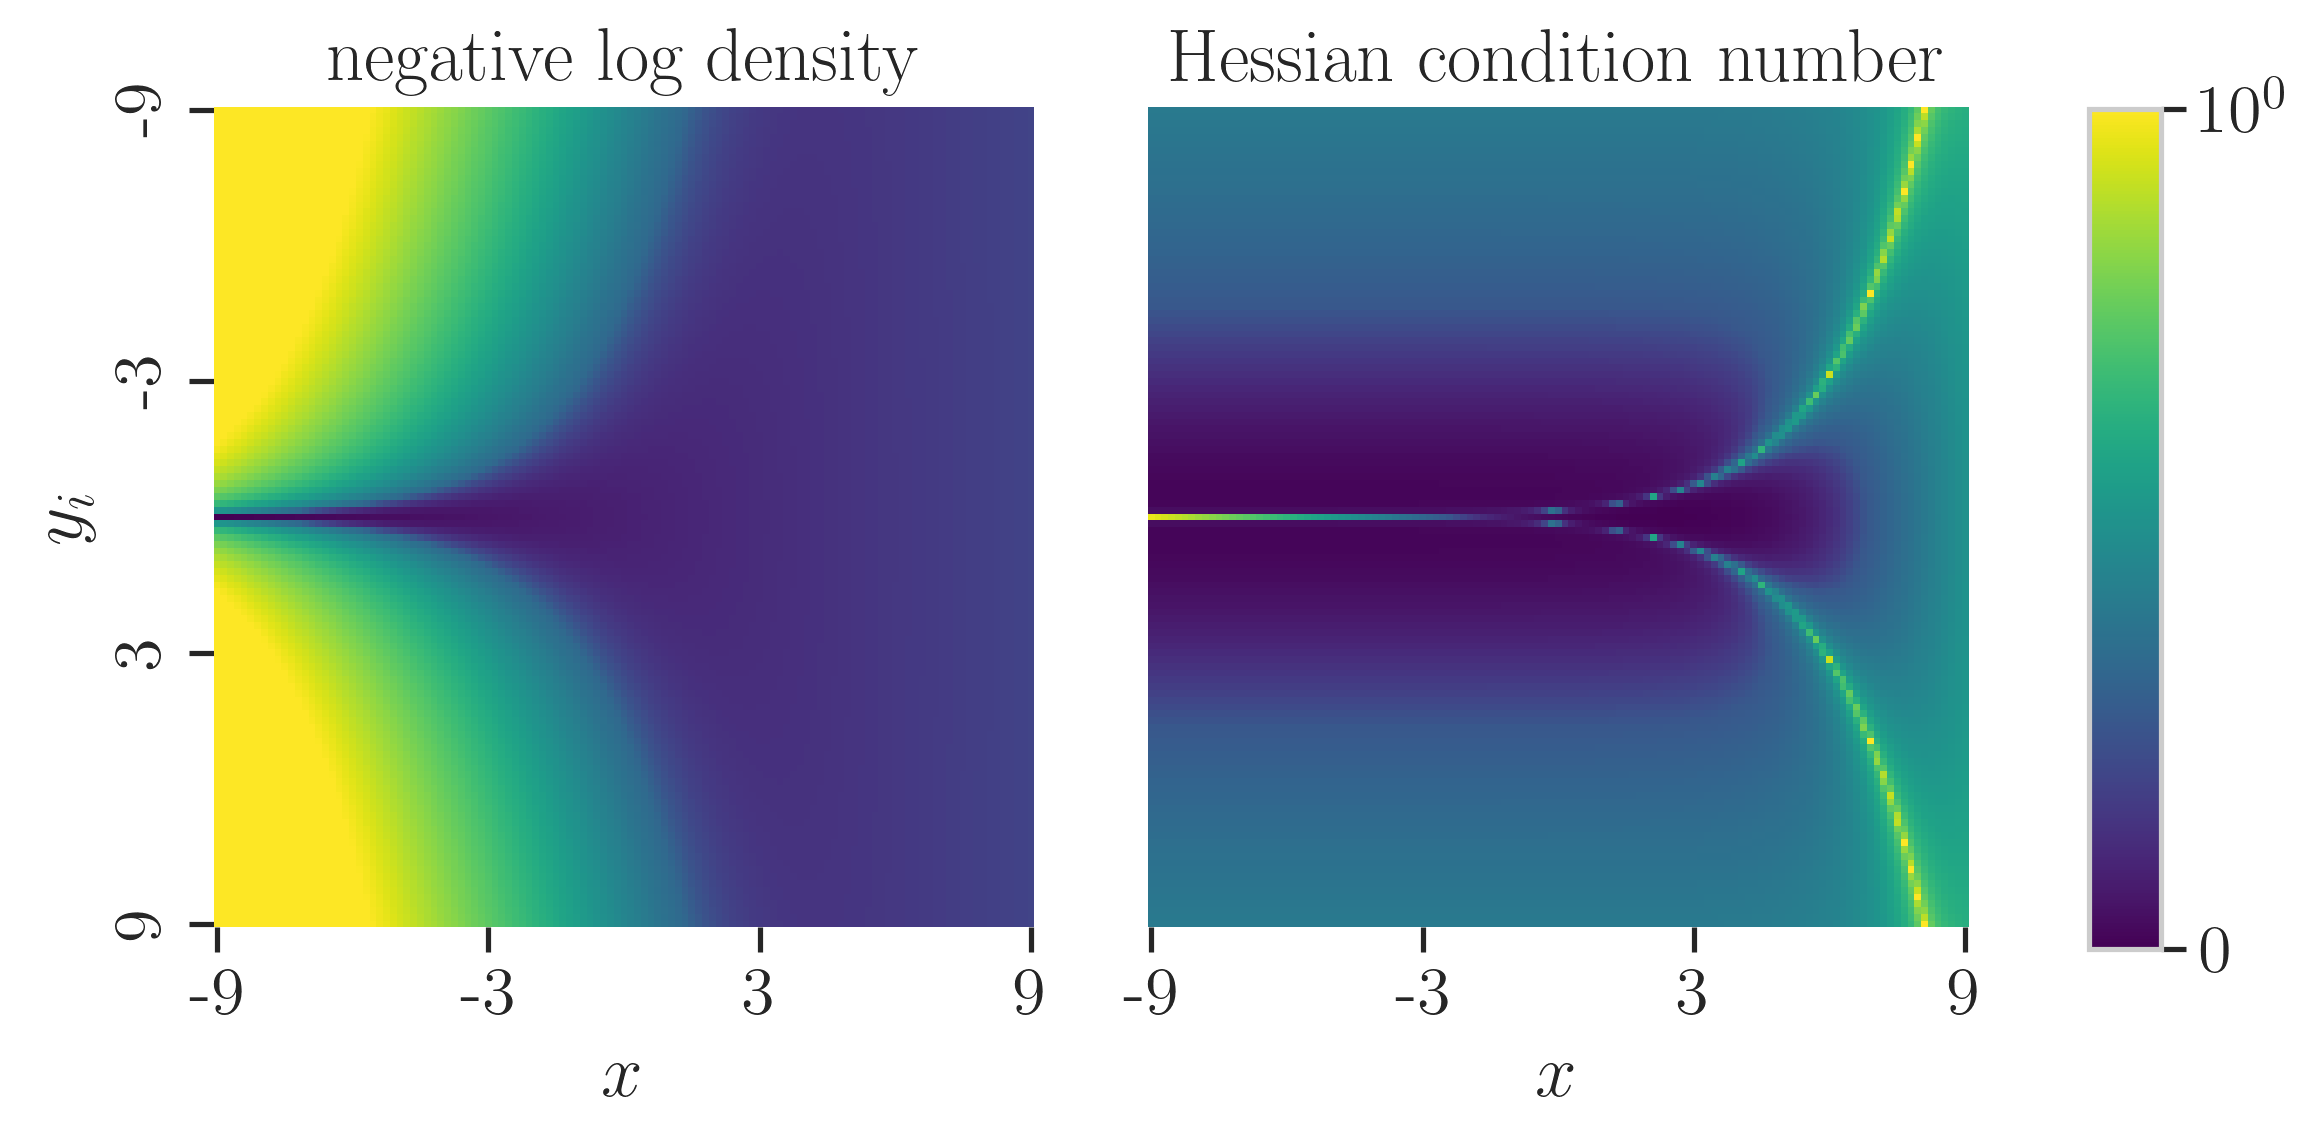

In [59]:
g = sns.FacetGrid(
    data=data,
    col_wrap=2,
    height=4,
    col="metric",
    col_order=["negative log density", "Hessian condition number"],
    # col_order=["log density", "Hessian condition number", "DR-GHMC stepsize"],
)

def plot_heatmap(data, color, **kwargs):
    cur_data = data["value"].values.reshape(len(y_values), len(x_values))
    cur_data = pd.DataFrame(cur_data, index=y_values, columns=x_values)
    metric = data["metric"].values[0]
    # norm = get_norm(metric)
    norm=SymLogNorm(linthresh=100, vmax=1e5)
    
    sns.heatmap(
        data = cur_data,
        cmap="viridis",
        cbar=False,
        norm=norm,
        xticklabels=40,
        yticklabels=40,
        square=True,
        ax=plt.gca(),
    )
    
g.map_dataframe(plot_heatmap)

# iterate over axis and add x and y ticks
for i, ax in enumerate(g.axes.flat):
    ax.xaxis.tick_bottom()
    if i == 0:
        ax.yaxis.tick_left()
    # cbar = ax.collections[0].colorbar
    # cbar.ax.tick_params(size=0)    

plt.subplots_adjust(right=0.8)
plt.colorbar(label="", mappable=plt.cm.ScalarMappable(norm=SymLogNorm(linthresh=100), cmap="viridis"), cax=g.fig.add_axes([0.85, 0.15, 0.03, 0.7]))
g.set_xlabels(r"$x$")
g.set_ylabels(r"$y_i$")
# set the ticks and tick labels
g.set_xticklabels(labels=[f"{x:.0f}" for x in x_values[::40]])
g.set_yticklabels(labels=[f"{y:.0f}" for y in y_values[::40]])
g.set_titles(col_template="{col_name}")

# Figure 2

In [8]:
data = data.melt(
    id_vars=["x", "y"],
    value_vars=["negative log density", "gradient norm", "Hessian condition number"],
    var_name="metric",
    value_name="value",
)

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


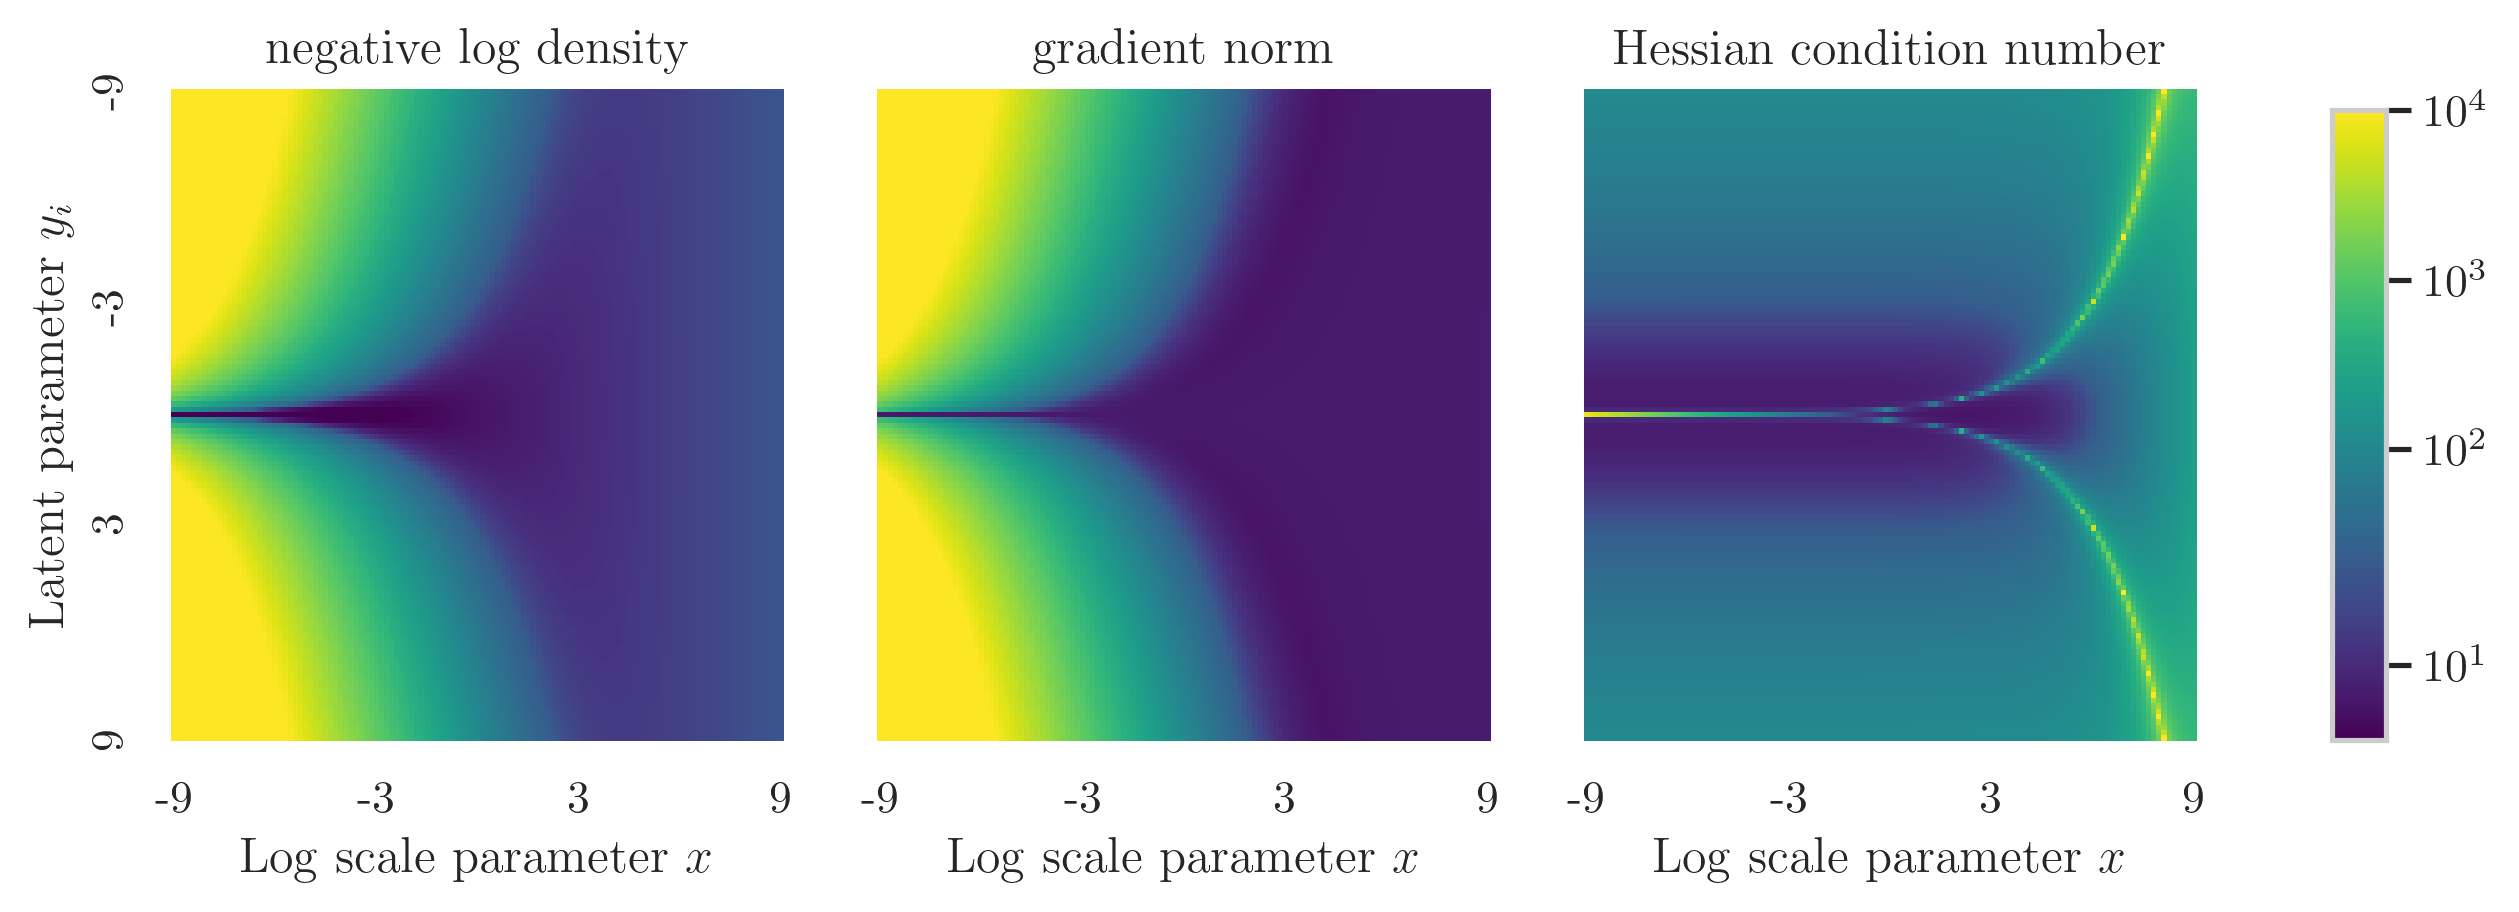

In [9]:
g = sns.FacetGrid(
    data=data,
    col_wrap=3,
    col="metric",
    col_order=["negative log density", "gradient norm", "Hessian condition number"],
)

def plot_heatmap(data, color, **kwargs):
    cur_data = data["value"].values.reshape(len(y_values), len(x_values))
    cur_data = pd.DataFrame(cur_data, index=y_values, columns=x_values)
    
    sns.heatmap(
        data = cur_data,
        cmap="viridis",
        norm=SymLogNorm(linthresh=50, vmin=-1e1, vmax=1e5),
        xticklabels=40,
        yticklabels=40,
        cbar = False,
        ax=plt.gca(),
    )

g.map_dataframe(plot_heatmap)
plt.subplots_adjust(right=0.8)
plt.colorbar(label="", mappable=plt.cm.ScalarMappable(norm=SymLogNorm(linthresh=25, vmin=1e-2, vmax=1e4), cmap="viridis"), cax=g.fig.add_axes([0.85, 0.15, 0.02, 0.7]))

g.set_xlabels(r"Log scale parameter $x$")
g.set_ylabels(r"Latent parameter $y_i$")
g.set_xticklabels(labels=[f"{x:.0f}" for x in x_values[::40]])
g.set_yticklabels(labels=[f"{y:.0f}" for y in y_values[::40]])
g.set_titles(col_template="{col_name}")

# Compute Avg Stepsize

In [10]:
res = []
for i in range(10):
    res += [2 / (4 ** i)]
print(res)

[2.0, 0.5, 0.125, 0.03125, 0.0078125, 0.001953125, 0.00048828125, 0.0001220703125, 3.0517578125e-05, 7.62939453125e-06]


In [11]:
def get_step(x, model):
    step_sizes = [2.0, 0.5, 0.125, 0.03125, 0.0078125, 0.001953125, 0.00048828125, 0.0001220703125, 3.0517578125e-05, 7.62939453125e-06]
    
    
    sampler = DrGhmcDiag(
        model=model,
        max_proposals=len(step_sizes),
        leapfrog_step_sizes=step_sizes,
        leapfrog_step_counts=[1] * len(step_sizes),
        damping=0.08,
        init=x,
        prob_retry=False
    )
    
    _, _ = sampler.sample()
    attempt = sampler.diagnostics["acceptance"] - 1
    return step_sizes[attempt]

In [12]:
num_repetitions = 100

x_values = np.linspace(-9, 9, 121)
y_values = np.linspace(-9, 9, 121)
step_size = np.zeros((len(x_values), len(y_values)))

for i, y_val in enumerate(y_values):
    print(i)
    for j, x_val in enumerate(x_values):
        
        arr = np.array([x_val] +  [y_val] * 9)
        steps = [get_step(arr, model) for k in range(num_repetitions)]
        step_size[i, j] = np.mean(steps)

0


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120


In [29]:
# cast x and y int values for better plotting
y_int = y_values.astype(int)
x_int = x_values.astype(int)
data = pd.DataFrame(step_size, index=y_int, columns=x_int)

Text(0.5, 1.0, 'Accepted DR-GHMC stepsize')

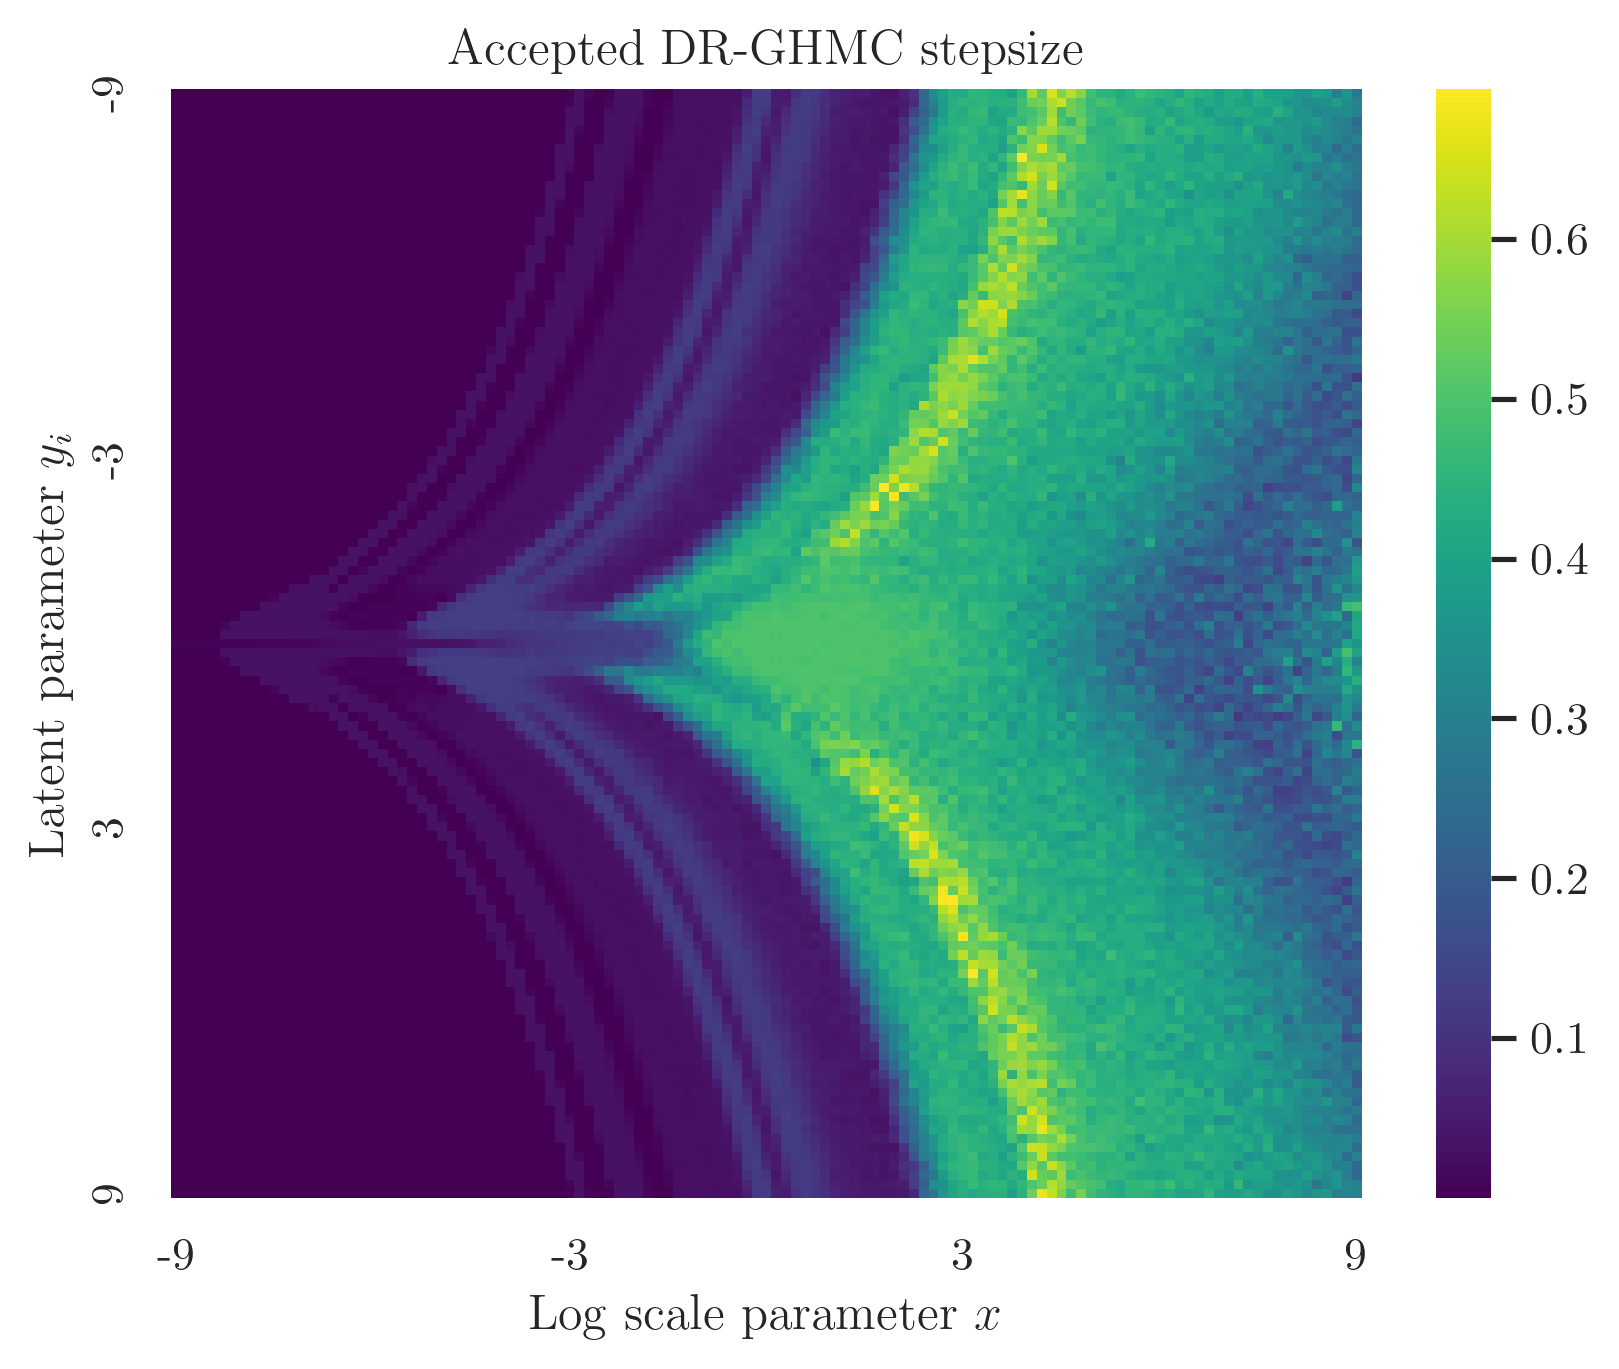

In [34]:
fig = sns.heatmap(
    data=data,
    cmap="viridis",
    # norm=LogNorm(),
    xticklabels=40,
    yticklabels=40,
)

plt.xlabel(r"Log scale parameter $x$")
plt.ylabel(r"Latent parameter $y_i$")
plt.title("Accepted DR-GHMC stepsize")

# Old

Text(0.5, 0.98, 'Gradient and Density for 10-Dim Funnel\n')

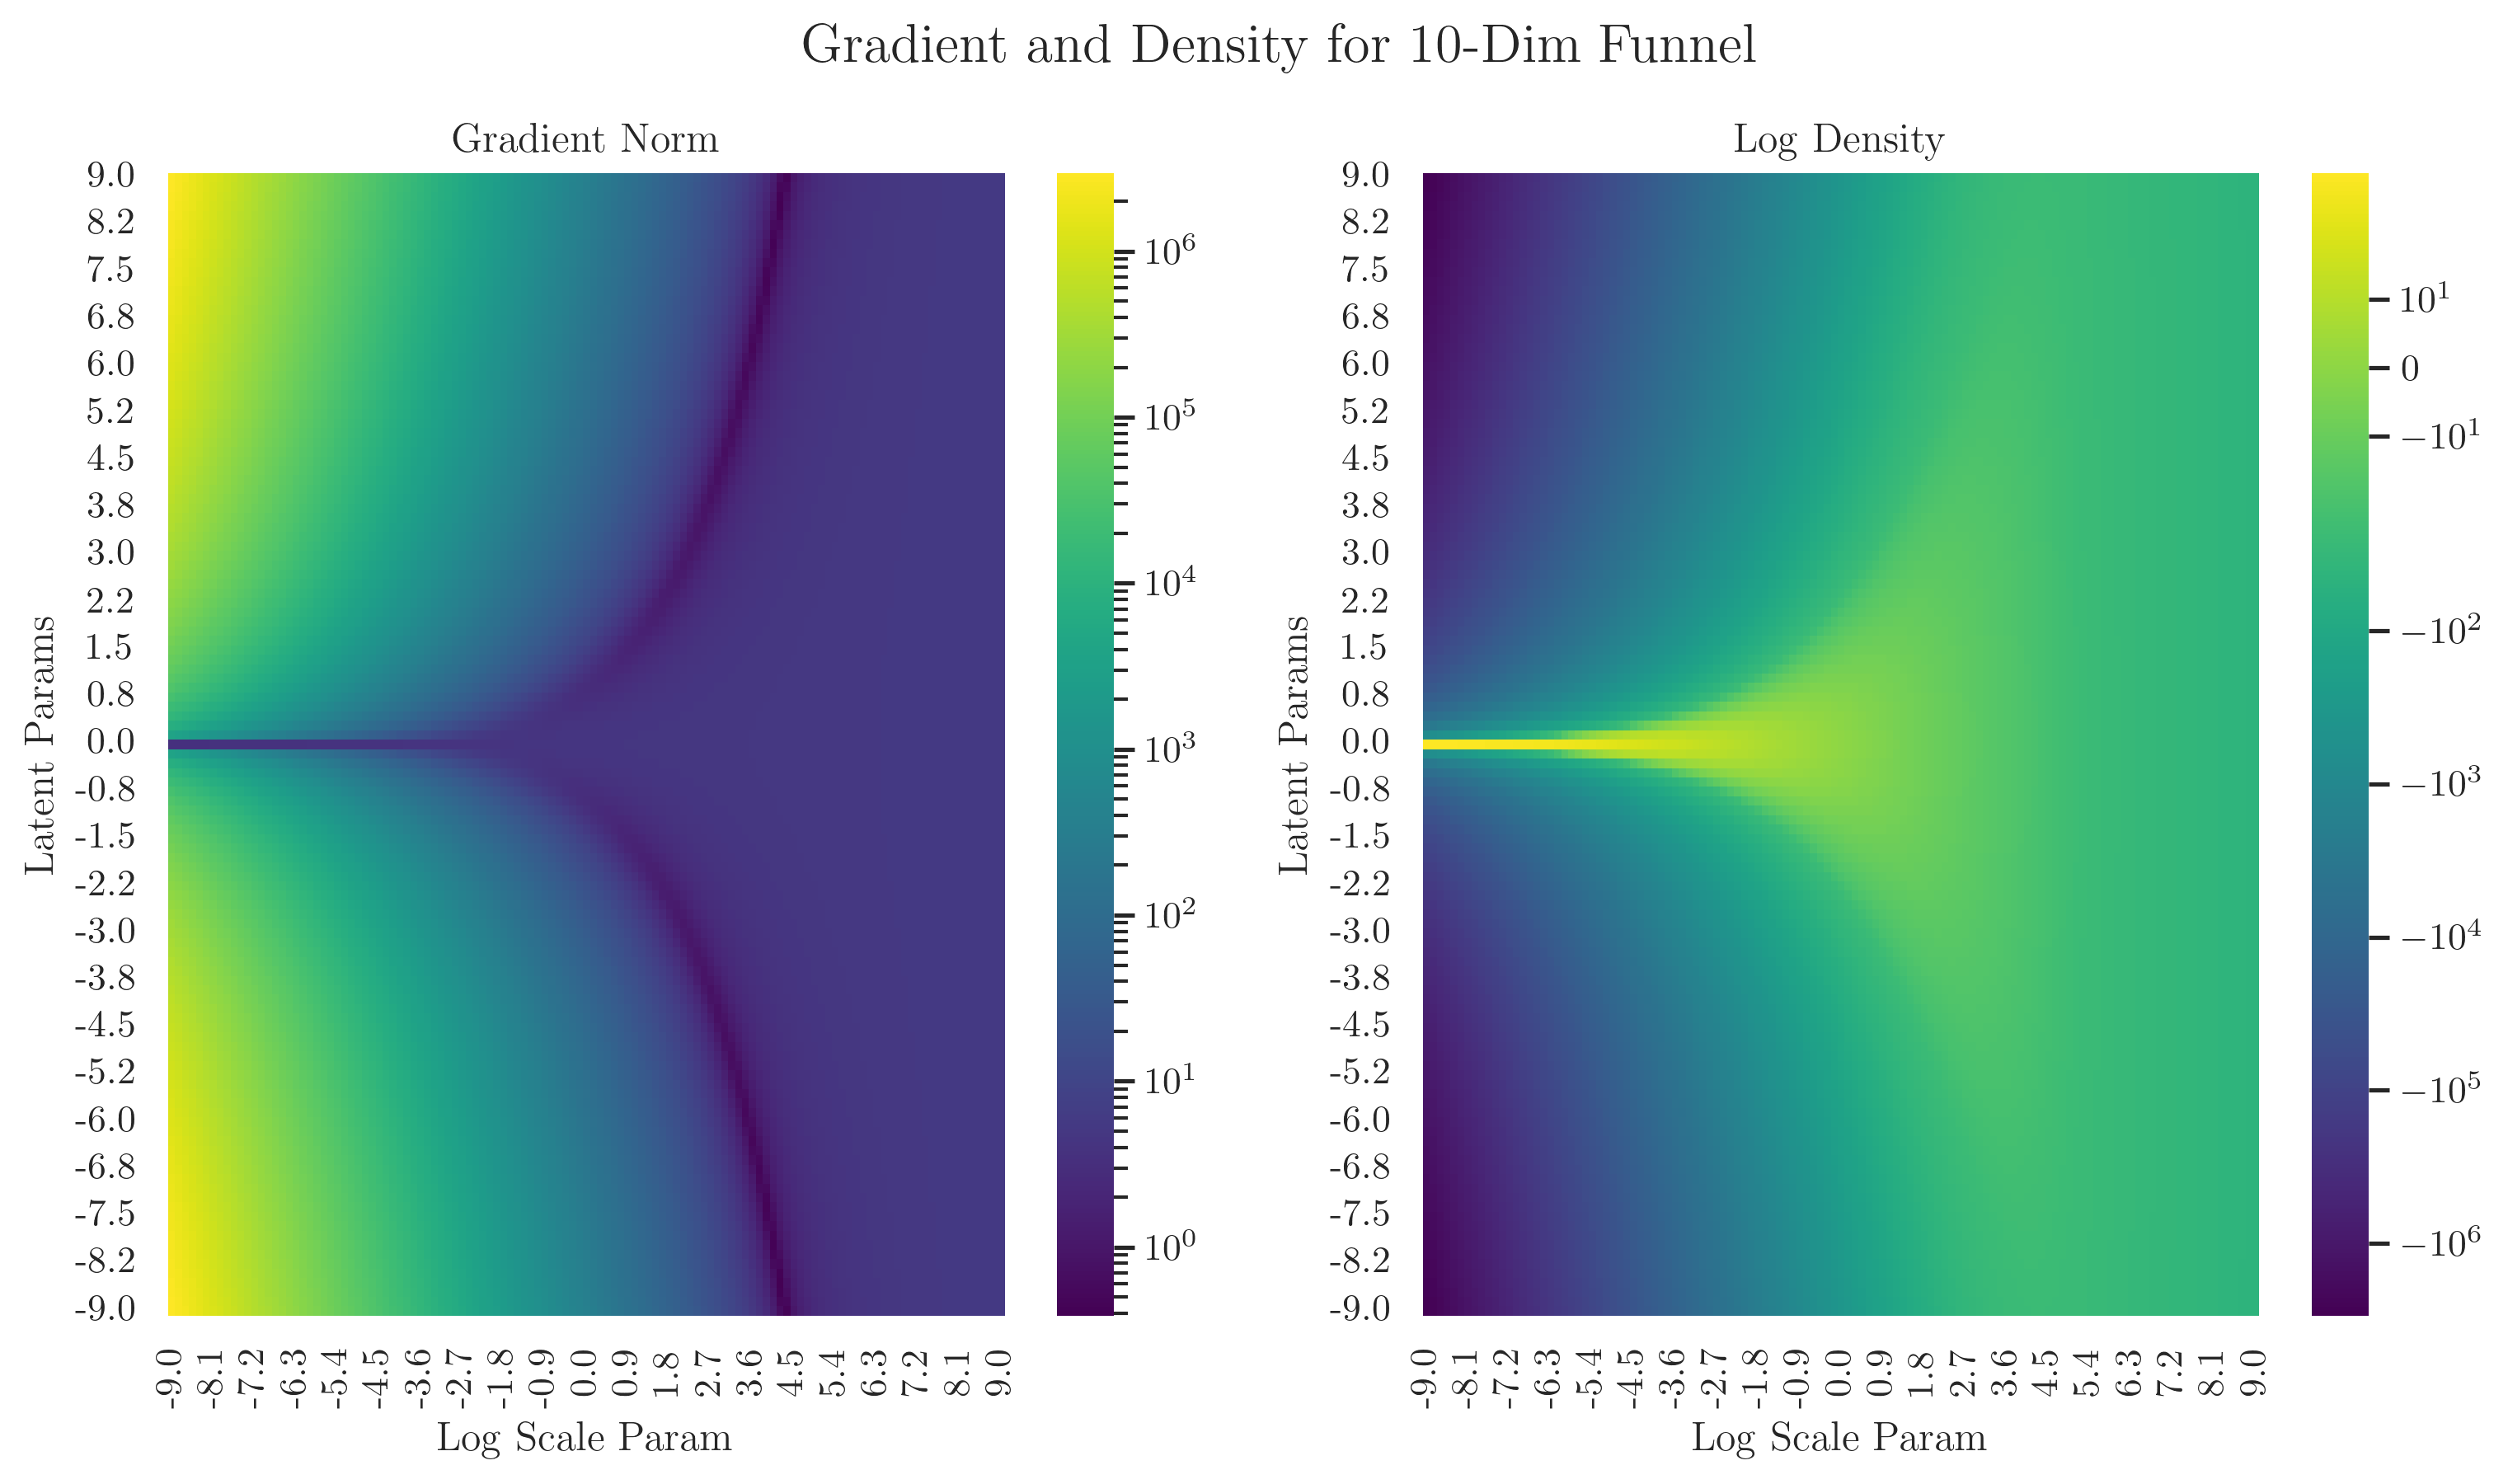

In [76]:
# Generate x values using numpy 10 dimensional linspace
x_values = np.linspace(-9, 9, 121)
y_values = np.linspace(9, -9, 121)
# Create an empty 2D array to store the gradient values
grad_values = np.zeros((len(x_values), len(y_values)))
density_values = np.zeros((len(x_values), len(y_values)))

# Calculate gradient values for each x value
for i, y_val in enumerate(y_values):
    for j, x_val in enumerate(x_values):
        arr = np.array([x_val] +  [y_val] * 9)
        log_density, gradient = model.log_density_gradient(arr)
        
        grad_values[i, j] = np.linalg.norm(gradient)
        density_values[i, j] = log_density


index = np.round(y_values, 1)
columns = np.round(x_values, 1)
grad_data = pd.DataFrame(grad_values, index=index, columns=columns)
density_data = pd.DataFrame(density_values, index=index, columns=columns)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Create a 2D heatmap using seaborn
sns.heatmap(
    data=grad_data, 
    norm=LogNorm(),
    cmap="viridis",
    ax=axes[0]
)
axes[0].set_ylabel("Latent Params")
axes[0].set_xlabel("Log Scale Param")
axes[0].set_title("Gradient Norm")

sns.heatmap(
    data=density_data,
    # vmin=-100,
    norm=SymLogNorm(linthresh=25),
    #vmax=0.1,
    cmap="viridis",
    ax=axes[1]
)
axes[1].set_ylabel("Latent Params")
axes[1].set_xlabel("Log Scale Param")
axes[1].set_title("Log Density")

fig.suptitle("Gradient and Density for 10-Dim Funnel\n", fontsize=16)


Text(0.5, 1.0, 'Log Density')

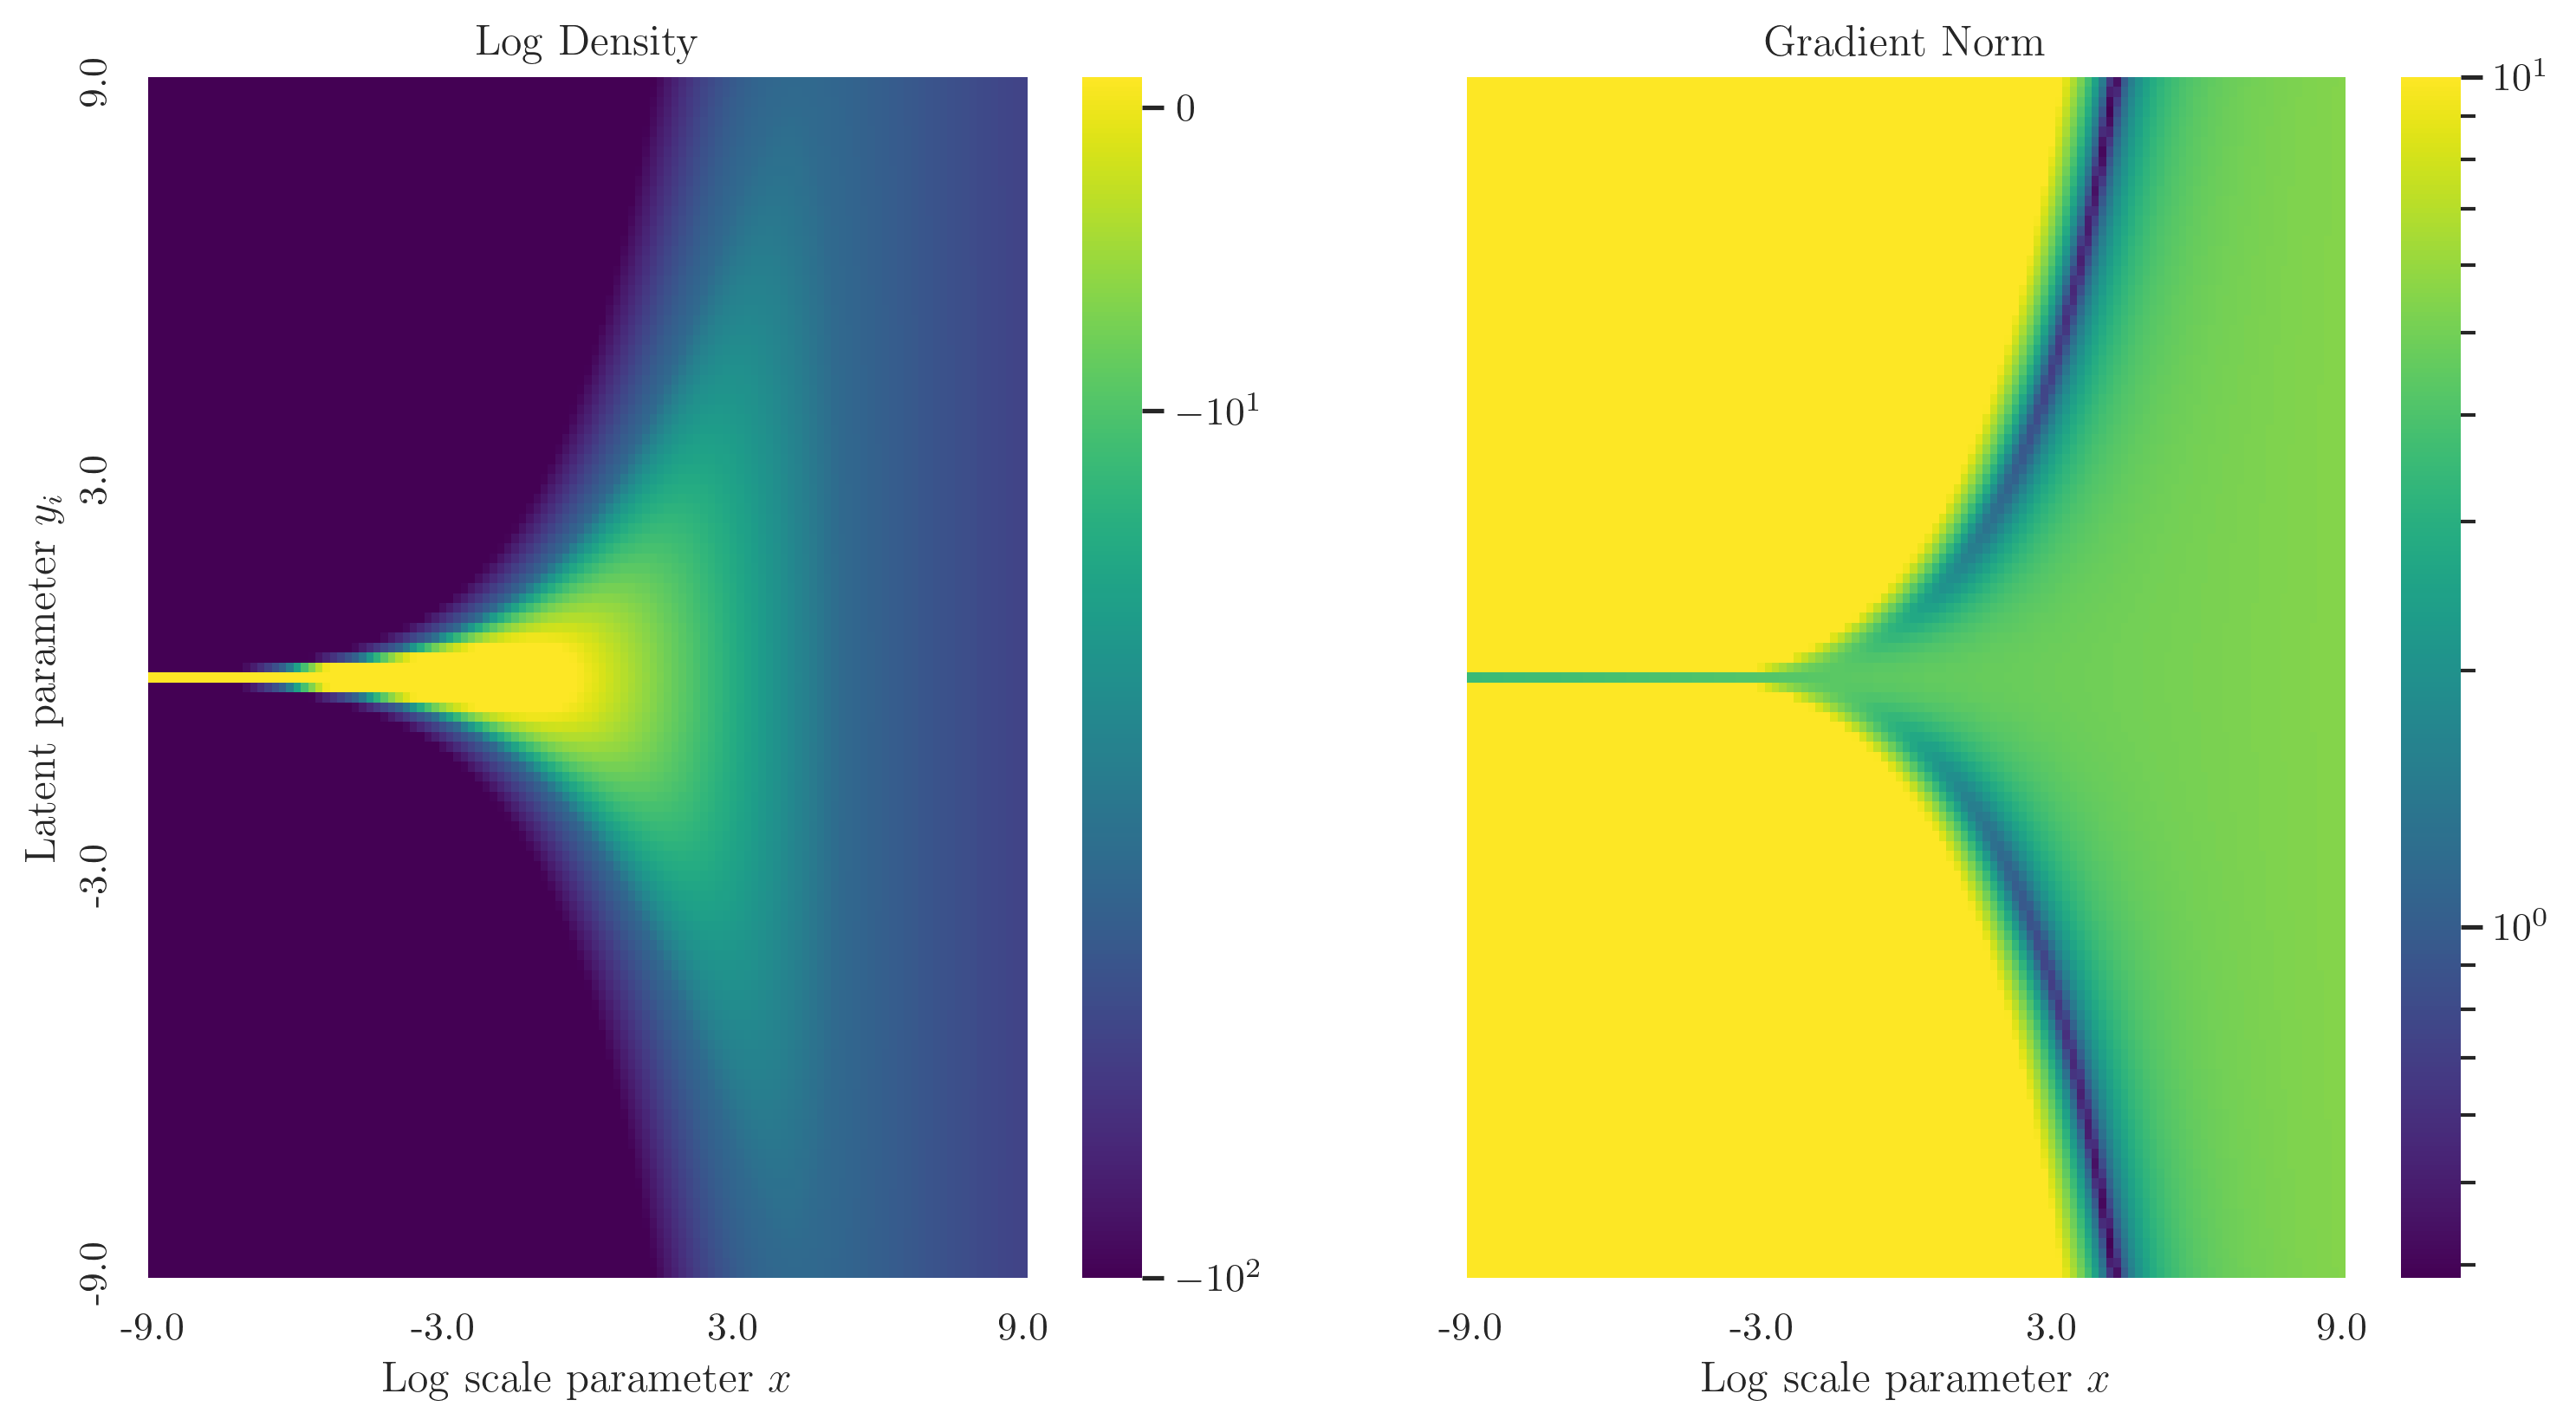

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm
import pandas as pd

# Generate x values using numpy 10 dimensional linspace
x_values = np.linspace(-9, 9, 121)
y_values = np.linspace(9, -9, 121)
# Create an empty 2D array to store the gradient values
grad_values = np.zeros((len(x_values), len(y_values)))
density_values = np.zeros((len(x_values), len(y_values)))

# Calculate gradient values for each x value
for i, y_val in enumerate(y_values):
    for j, x_val in enumerate(x_values):
        arr = np.array([x_val] +  [y_val] * 9)
        log_density, gradient = model.log_density_gradient(arr)
        
        grad_values[i, j] = np.linalg.norm(gradient)
        density_values[i, j] = log_density


index = np.round(y_values, 1)
columns = np.round(x_values, 1)
grad_data = pd.DataFrame(grad_values, index=index, columns=columns)
density_data = pd.DataFrame(density_values, index=index, columns=columns)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Create a 2D heatmap using seaborn
sns.heatmap(
    data=grad_data, 
    norm=LogNorm(vmax=10),
    cmap="viridis",
    xticklabels=40,
    ax=axes[1]
)
axes[1].set_xlabel(r'Log scale parameter $x$')
axes[1].set_title("Gradient Norm")

sns.heatmap(
    data=density_data,
    # vmin=-100,
    norm=SymLogNorm(linthresh=25, vmin=-100, vmax=1),
    #vmax=0.1,
    cmap="viridis",
    xticklabels=40,
    yticklabels=40,
    ax=axes[0]
)

axes[0].set_ylabel(r'Latent parameter $y_i$')
axes[0].set_xlabel(r'Log scale parameter $x$')
axes[0].set_title("Log Density")